In [152]:
import IPython
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchaudio

In [153]:
# Load audio from file
audio_input, sample_rate = torchaudio.load('data/atc_clip.wav')

# Resample to 16000 Hz
sample_rate = 16000
resampler = torchaudio.transforms.Resample(sample_rate, sample_rate)
audio_input = resampler(audio_input)

# Clip audio to 8 seconds
audio_input = audio_input[:, :8 * sample_rate]

In [154]:
def generate_frequency_noise_old(audio_input, epsilon, low_freq, high_freq):
  t = torch.arange(sample_rate * 10).float() / sample_rate

  noise = torch.zeros_like(t)

  norm = (high_freq - low_freq) / 100

  for i in range(low_freq, high_freq, 100):
    noise += (1/norm) * torch.sin(2 * torch.pi * i * t)

  # noise = torch.randn_like(audio_input) * epsilon
  # noise = torch.fft.rfft(noise)
  # noise = torch.abs(noise)
  # noise = torch.where(noise > lower_bound, noise, torch.zeros_like(noise))
  # noise = torch.where(noise < upper_bound, noise, torch.zeros_like(noise))
  # noise = torch.fft.irfft(noise)
  # noise_filtered = torchaudio.functional.bandpass_biquad(noise, 16000, low_freq, high_freq)

  return noise.unsqueeze(0)

def fftnoise(f):
  f = np.array(f, dtype='complex')
  Np = (len(f) - 1) // 2
  phases = np.random.rand(Np) * 2 * np.pi
  phases = np.cos(phases) + 1j * np.sin(phases)
  f[1:Np+1] *= phases
  f[-1:-1-Np:-1] = np.conj(f[1:Np+1])
  return np.fft.ifft(f).real

def band_limited_noise(min_freq, max_freq, samples=1024, samplerate=1):
  freqs = np.abs(np.fft.fftfreq(samples, 1/samplerate))
  f = np.zeros(samples)
  idx = np.where(np.logical_and(freqs>=min_freq, freqs<=max_freq))[0]
  f[idx] = 1
  return torch.from_numpy(fftnoise(f)).float().unsqueeze(0)

def generate_boring_noise(audio_input, epsilon):
  noise = torch.randn_like(audio_input) * epsilon
  return noise

def generate_cool_noise(audio_input, epsilon):
  noise = band_limited_noise(4000, 8000, samples=audio_input.shape[1], samplerate=16000) * 320 * epsilon
  return noise

noise1 = generate_boring_noise(audio_input, 0.1)
noise2 = generate_cool_noise(audio_input, 0.1)

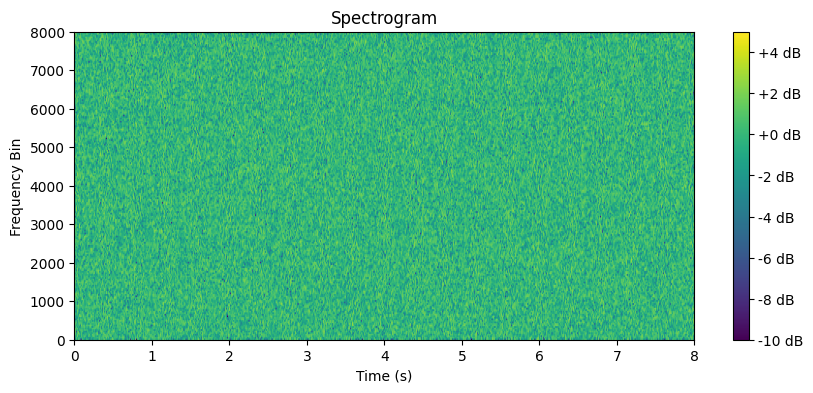

/tmp/ipykernel_162827/71753996.py:17: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(spectrogram_np[0, :, :]), aspect='auto', origin='lower',


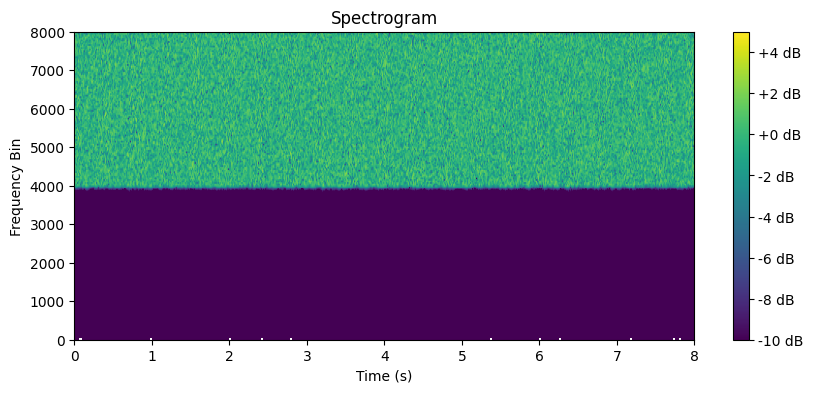

In [155]:
def create_spectrogram(waveform, sample_rate):
  # Create a spectrogram from the waveform
  spectrogram = torchaudio.transforms.Spectrogram()(waveform)

  # Convert the spectrogram to numpy array for plotting
  spectrogram_np = spectrogram.numpy()

  # Get number of frames from the spectrogram shape
  num_frames = spectrogram_np.shape[2]

  # Get the time axis values
  duration = waveform.shape[1] / sample_rate
  time_axis = np.linspace(0, duration, num_frames)

  # Plot and save the spectrogram
  plt.figure(figsize=(10, 4))
  plt.imshow(np.log(spectrogram_np[0, :, :]), aspect='auto', origin='lower',
             vmin=-10, vmax=5, extent=[time_axis.min(), time_axis.max(), 0, sample_rate/2])
  plt.title('Spectrogram')
  plt.xlabel('Time (s)')
  plt.ylabel('Frequency Bin')
  plt.colorbar(format="%+2.0f dB")

  plt.show()

create_spectrogram(noise1, sample_rate)
create_spectrogram(noise2, sample_rate)

In [156]:
IPython.display.Audio(noise, rate=sample_rate)